In [ ]:
import sys
sys.path.append('..')
from phase_o_matic import presto_phase_delay

dem_dataset = xr.Dataset()

presto_phase_delay(date = '2020-01-03', geometry = )

read ISCE geometry files: hgt/los/lat/lon.rdr
calculate tropospheric delay from GRB files...
------------------------------------------------
INFO: INCIDENCE ANGLE AS AN ARRAY
INFO: AREA COVERAGE IN SNWE: (33.85, 30.05, 129.05, 132.45)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 15 LATITUDES AND 13 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
True
True
PROGRESS: COMPUTING DELAY FUNCTIONS
INFO: INCIDENCE ANGLE AS AN ARRAY
INFO: AREA COVERAGE IN SNWE: (33.85, 30.05, 129.05, 132.45)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 15 LATITUDES AND 13 LONGITUDES
PROGRESS: INTERPOLATING FROM PRESSURE TO HEIGHT LEVELS
True
True
PROGRESS: COMPUTING DELAY FUNCTIONS
PROGRESS: FINE INTERPOLATION OF HEIGHT LEVELS
PROGRESS: CREATE THE BILINEAR INTERPOLATION FUNCTION
PROGRESS: MAPPING THE DELAY
[============================================================]      0

2023-05-10 12:19:54,174 INFO Welcome to the CDS
2023-05-10 12:19:54,175 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-10 12:19:54,375 INFO Request is completed
2023-05-10 12:19:54,377 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data8/adaptor.mars.internal-1683655412.9633095-18625-7-392f59c2-c8e5-464a-a18d-2225df836dab.nc to ../data/phaseo_era/ERA5_2010-10-17T14:00_129.25_30.25_132.25_33.75.nc (44.3K)
2023-05-10 12:19:54,877 INFO Download rate 88.8K/s  
2023-05-10 12:19:58,800 INFO Welcome to the CDS
2023-05-10 12:19:58,801 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-10 12:19:59,047 INFO Request is completed
2023-05-10 12:19:59,048 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data0/adaptor.mars.internal-1683655423.4881275-7301-16-7467e39b-7771-4286-93fd-671b26cd

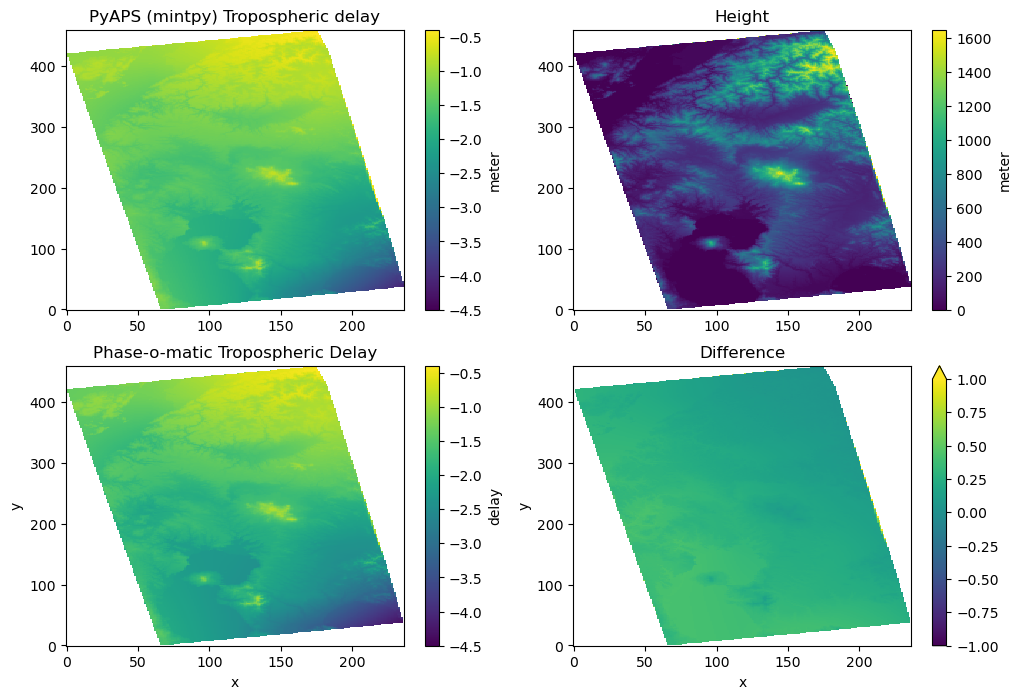

In [5]:
import pyaps3 as pa
import os
import matplotlib.pyplot as plt

# run pyaps3
data_dir = '../pyAPS_data'
# read geometry files
print('read ISCE geometry files: hgt/los/lat/lon.rdr')
dem_pa = pa.utils.read_data(os.path.join(data_dir, 'hgt.rdr'))
inc = pa.utils.read_data(os.path.join(data_dir, 'los.rdr'), dname='inc')
lat = pa.utils.read_data(os.path.join(data_dir, 'lat.rdr'))
lon = pa.utils.read_data(os.path.join(data_dir, 'lon.rdr'))

# calculate
print('calculate tropospheric delay from GRB files...')
print('------------------------------------------------')
grb_file1 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20101017_14.grb')
grb_file2 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20110117_14.grb')
obj1 = pa.PyAPS(grb_file1, dem=dem_pa, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
obj2 = pa.PyAPS(grb_file2, dem=dem_pa, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
phs = obj2.getdelay(wvl = 0.238403545) - obj1.getdelay(wvl = 0.238403545)

# regrid data to xarray
import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.append('..')

from phase_o_matic.utils import regrid_twoD_coords

dem = pa.utils.read_data(os.path.join(data_dir, 'hgt.rdr'))
dem = xr.DataArray(dem, 
             coords = {
    "lat": (("y", "x"), lat),
    "lon": (("y", "x"), lon)
},
dims = ["y","x"])
dem = regrid_twoD_coords(dem)

inc = np.deg2rad(pa.utils.read_data(os.path.join(data_dir, 'los.rdr'), dname='inc'))
inc= xr.DataArray(inc, 
             coords = {
    "lat": (("y", "x"), lat),
    "lon": (("y", "x"), lon)
},
dims = ["y","x"])
inc = regrid_twoD_coords(inc)


pyaps_phase = xr.DataArray(phs, 
             coords = {
    "lat": (("y", "x"), lat),
    "lon": (("y", "x"), lon)
},
dims = ["y","x"])
pyaps_phase = regrid_twoD_coords(pyaps_phase)

dem_ds = dem.to_dataset(name = 'dem')
dem_ds['inc'] = inc

dates = (pd.to_datetime('2010-10-17T14:00'), pd.to_datetime('2011-01-17T14:00'))

# Phase o matic now
from shapely import geometry
from phase_o_matic.download import download_era
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_heights, geopotential_to_geopotential_heights
from phase_o_matic.phase_delay import calculate_refractive_indexes, get_delay


eras = []
for date in dates:
    out_fp = download_era(date, out_dir = '../data/phaseo_era/', subset = geometry.box(129.25, 30.25, 132.25, 33.75), humid_param = 'specific_humidity')
    era = xr.open_dataset(out_fp)
    era = convert_pressure_to_pascals(era)
    era = get_vapor_partial_pressure(era)
    era = geopotential_to_geopotential_heights(era)
    if date == pd.to_datetime('2010-10-17T14:00'):
        ds = interpolate_to_heights(era, max_alt = obj1.hgt[-1])
    elif date == pd.to_datetime('2011-01-17T14:00'):
        ds = interpolate_to_heights(era, max_alt = obj2.hgt[-1])
    
    ds = calculate_refractive_indexes(ds)
    ds = get_delay(ds, dem_ds, wavelength = 0.238403545)
    eras.append(ds['delay'])
era = xr.concat(eras, dim = 'time')

# now plot the two
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

titles = ['PyAPS (mintpy) Tropospheric delay', 'Height']
for ax, data, title in zip(axes[0, :], [pyaps_phase.data, dem_ds.dem.data], titles):
    if title == 'Height':
        im = ax.imshow(data, interpolation='nearest', vmin = 0, vmax = 1650, aspect="auto")
    else:
        im = ax.imshow(data, interpolation='nearest', aspect="auto", vmin = -4.5, vmax = -0.4)
    # axis format
    ax.invert_yaxis()
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('meter')

phaseo = (era.isel(time = 1) - era.isel(time = 0))
phaseo.plot(ax = axes[1, 0], vmin = -4.5, vmax = -0.4)
(pyaps_phase - phaseo).plot(ax = axes[1, 1], vmax = 1, vmin = -1)
axes[1,0].set_title('Phase-o-matic Tropospheric Delay')
axes[1,1].set_title('Difference')

plt.savefig('../images/pyaps_phaseo_compare.png')